In [1]:
import numpy as np
import pandas as pd
import pickle
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import yaml
import os

pd.set_option("display.max_columns", None) # 表示する列数の制限を解除

import sys
sys.path.append("..") # 親ディレクトリを追加
from module.path_reader import PathReader

reader = PathReader("../file_path_NotePC.json") # NotePC用
# reader = PathReader("../file_path_Desktop.json") # Desktop用

In [6]:
with open(os.path.join(reader.get_path('data_folder'), 'merged_table_260208.pkl'), "rb") as f:
    model = pickle.load(f)

print(model.columns)
print(f"Number of items: {len(model.columns)}")
print(f"Number of rows: {len(model)}")

Index(['race_id', 'date', 'rank', 'is_win', 'is_place', 'wakuban', 'umaban',
       'horse_id', 'weight_carried', 'jockey_id', 'margin', 'popularity',
       'odds', 'last3f', 'trainer_id', 'sex', 'age', 'time_sec', 'passing1',
       'passing2', 'passing3', 'passing4', 'weight_horse', 'weight_diff',
       'weather', 'num_of_horses', 'course_condition', 'course_state',
       'distance_length', 'race_course_code', 'log_odds_avg3', 'log_odds_avg5',
       'log_odds_avg10', 'log_odds_zscore_avg3', 'log_odds_zscore_avg5',
       'log_odds_zscore_avg10', 'popularity_inverse_avg3',
       'popularity_inverse_avg5', 'popularity_inverse_avg10',
       'popularity_bucket_avg3', 'popularity_bucket_avg5',
       'popularity_bucket_avg10', 'weight_avg_in_race',
       'weight_per_body_weight', 'finish_position_inverse_avg3',
       'finish_position_inverse_avg5', 'finish_position_inverse_avg10',
       'expected_vs_actual_gap_avg3', 'expected_vs_actual_gap_avg5',
       'expected_vs_actual_gap_a

In [7]:
with open(reader.get_path("features"), 'r', encoding='utf-8') as f:
    data = yaml.safe_load(f)
    features = data['features']
    features = [f for f in data['features'] if f not in ['horse_id', 'race_id']]  # horse_idとrace_idを除外
X = model[features]
y = model['is_win']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [9]:
params = {
    'objective': 'binary', # 2クラス分類
    'metric': 'binary_logloss', # ロス関数
    'boosting_type': 'gbdt', # 勾配ブースティング
    'learning_rate': 0.1, # 学習率(小さいほど慎重に学習、ただし学習時間は長くなる)
    'num_leaves': 31, # 木の葉の数(複雑なモデルほど大きく)
    'verbose': -1, # 全てのログの出力を非表示
    'early_stopping_round': 30, # 30回連続で改善しなければ終了
    'num_boost_round': 300 # 最大100本の木を作成
}

In [40]:
ml_model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], valid_names=['train', 'eval'])
y_pred_prob = ml_model.predict(X_test, num_iteration=ml_model.best_iteration)
y_pred = (y_pred_prob >= 0.01).astype(int) # 確率を0.5で閾値判定
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

results = X_test.copy() # 学習データ
results["actual"] = y_test # 実際の予測対象
results["predicted"] = y_pred # 予測結果
results["predicted_prob"] = y_pred_prob # 予測確率

results.head(10)

Accuracy: 7.24%


,weather,num_of_horses,course_condition,course_state,distance_length,race_course_code,log_odds_avg3,log_odds_avg5,log_odds_avg10,log_odds_zscore_avg3,log_odds_zscore_avg5,log_odds_zscore_avg10,popularity_inverse_avg3,popularity_inverse_avg5,popularity_inverse_avg10,popularity_bucket_avg3,popularity_bucket_avg5,popularity_bucket_avg10,weight_avg_in_race,weight_per_body_weight,finish_position_inverse_avg3,finish_position_inverse_avg5,finish_position_inverse_avg10,expected_vs_actual_gap_avg3,expected_vs_actual_gap_avg5,expected_vs_actual_gap_avg10,time_diff_from_winner_avg3,time_diff_from_winner_avg5,time_diff_from_winner_avg10,time_zscore_in_race_avg3,time_zscore_in_race_avg5,time_zscore_in_race_avg10,margin_to_winner_avg3,margin_to_winner_avg5,margin_to_winner_avg10,final_3f_rank_avg3,final_3f_rank_avg5,final_3f_rank_avg10,final_3f_diff_avg3,final_3f_diff_avg5,final_3f_diff_avg10,final_3f_zscore_avg3,final_3f_zscore_avg5,final_3f_zscore_avg10,log_prize_avg3,log_prize_avg5,log_prize_avg10,passing_1st_rel_avg3,passing_1st_rel_avg5,passing_1st_rel_avg10,passing_2nd_rel_avg3,passing_2nd_rel_avg5,passing_2nd_rel_avg10,passing_3rd_rel_avg3,passing_3rd_rel_avg5,passing_3rd_rel_avg10,passing_4th_rel_avg3,passing_4th_rel_avg5,passing_4th_rel_avg10,actual,predicted,predicted_prob
51063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.072413
29383,0.0,18.0,0.0,0.0,1400.0,4.0,2.356810,3.079349,NaN,-0.409782,0.09961,NaN,0.214286,0.163294,NaN,2.333333,2.8,NaN,-0.444443,0.121212,0.388889,0.298333,NaN,2.333333,3.8,NaN,0.666667,0.58,NaN,-0.820341,-0.676062,NaN,5.1,4.22,NaN,1.833333,1.7,NaN,0.433333,0.26,NaN,-1.133563,-1.267183,NaN,6.132995,NaN,NaN,0.332323,0.249394,NaN,0.238384,0.19303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.066199
38143,0.0,13.0,0.0,1.0,1600.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.384617,0.112705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.093055
114,0.0,17.0,0.0,0.0,2000.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.588234,0.120293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.065395
9354,0.0,16.0,0.0,1.0,1200.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.312500,0.113445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0.074054
61101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.072413
59586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.072413
26161,1.0,16.0,1.0,1.0,1150.0,3.0,2.305895,2.325010,NaN,-0.664562,-0.70972,NaN,0.430556,0.338333,NaN,2.333333,2.2,NaN,1.375000,0.113281,0.414286,0.388571,NaN,-1.000000,0.0,NaN,0.733333,0.56,NaN,-0.306611,-0.605302,NaN,13.3,14.90,NaN,4.500000,4.4,NaN,0.300000,0.26,NaN,-1.011651,-0.944131,NaN,NaN,NaN,NaN,0.208333,0.337500,NaN,0.187500,0.35000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.071071
15192,0.0,16.0,0.0,0.0,1200.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.375000,0.121076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.062069
6010,0.0,16.0,0.0,1.0,1400.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.

In [41]:
print(f"Actual values:\n{results['actual'].value_counts()}")
print(f"Predicted values:\n{results['predicted'].value_counts()}")

# 的中率の表示
both_one_count = ((results["actual"] == 1) & (results["predicted"] == 1)).sum()
print(f"Hitting rate: {both_one_count / (results['actual'] == 1).sum():.2f}")

Actual values:
actual
0.0    11944
1.0      922
Name: count, dtype: int64
Predicted values:
predicted
1    12857
0        9
Name: count, dtype: int64
Hitting rate: 1.00


In [12]:
both_one_count = ((results["actual"] == 1) & (results["predicted"] == 1)).sum()
print(f"actual=1.0 かつ predicted=1.0 の行数: {both_one_count}")

actual=1.0 かつ predicted=1.0 の行数: 230


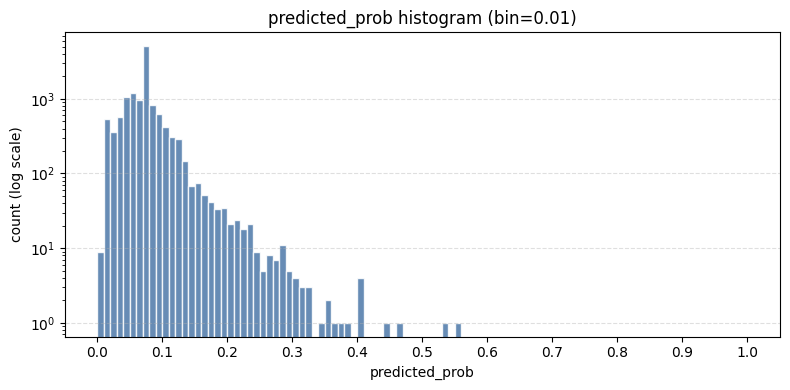

In [17]:
import numpy as np
import matplotlib.pyplot as plt

data = results["predicted_prob"].clip(0, 1)
bins = np.linspace(0, 1, 101)

plt.figure(figsize=(8, 4))
plt.hist(data, bins=bins, edgecolor="white", color="#4C78A8", alpha=0.85)
plt.yscale("log")
plt.xticks(np.linspace(0, 1, 11))
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.xlabel("predicted_prob")
plt.ylabel("count (log scale)")
plt.title("predicted_prob histogram (bin=0.01)")
plt.tight_layout()
plt.show()

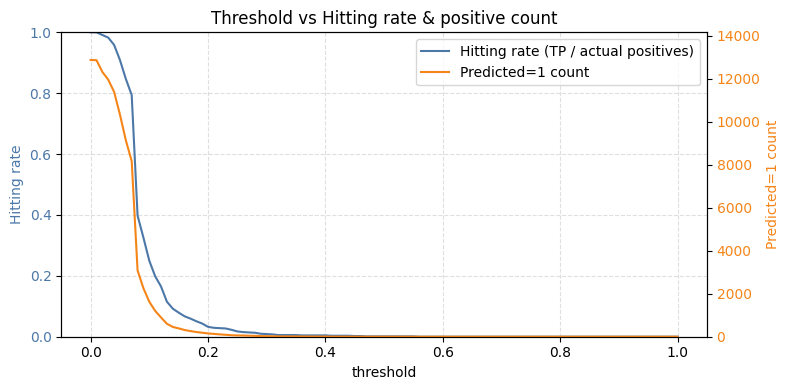

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Hitting rate = TP / actual positives (user definition)
thresholds = np.linspace(0, 1, 101)
hitting_rates = []
pred_positive_counts = []
actual_positives = (results["actual"] == 1).sum()

for t in thresholds:
    preds = (results["predicted_prob"] >= t).astype(int)
    tp = ((preds == 1) & (results["actual"] == 1)).sum()
    pred_pos = (preds == 1).sum()
    hitting_rates.append(tp / actual_positives if actual_positives > 0 else 0)
    pred_positive_counts.append(pred_pos)

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(thresholds, hitting_rates, color="#4C78A8", label="Hitting rate (TP / actual positives)")
ax1.set_xlabel("threshold")
ax1.set_ylabel("Hitting rate", color="#4C78A8")
ax1.tick_params(axis="y", labelcolor="#4C78A8")
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
ax2.plot(thresholds, pred_positive_counts, color="#F58518", label="Predicted=1 count")
ax2.set_ylabel("Predicted=1 count", color="#F58518")
ax2.tick_params(axis="y", labelcolor="#F58518")
ax2.set_ylim(0, max(pred_positive_counts) * 1.1)

lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper right")
ax1.grid(axis="both", linestyle="--", alpha=0.4)
plt.title("Threshold vs Hitting rate & positive count")
plt.tight_layout()
plt.show()

### SHAPを使った分析

In [10]:
import shap
import matplotlib.pyplot as plt

c:\Users\yasak\Desktop\mykeibaAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\yasak\Desktop\mykeibaAI\.venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


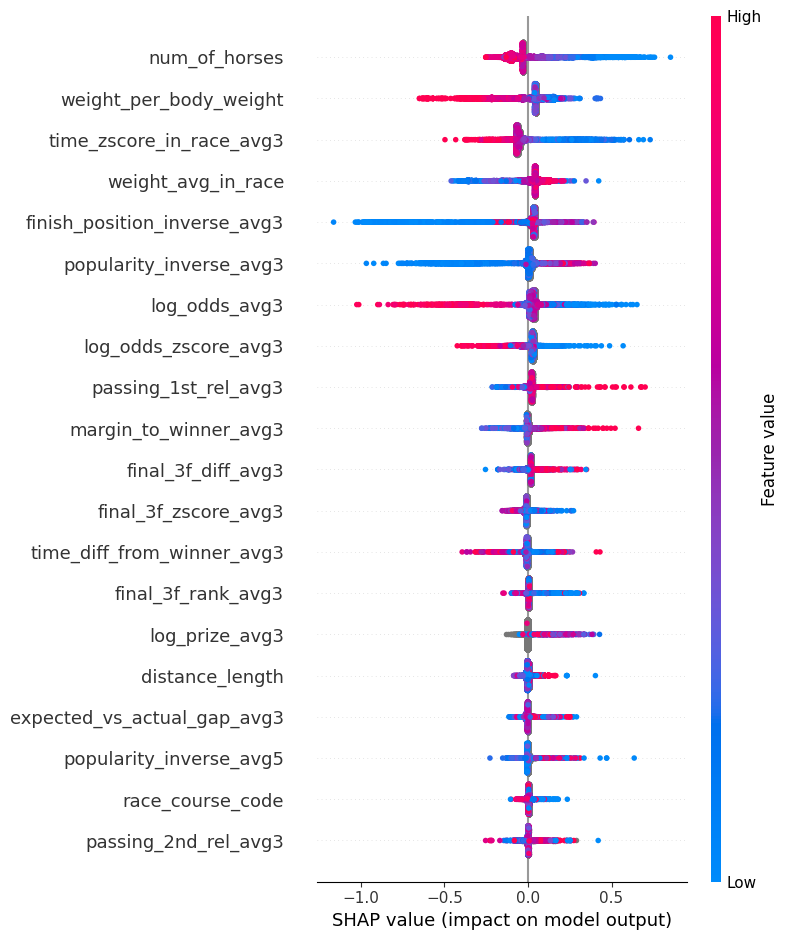

In [11]:
explainer = shap.TreeExplainer(ml_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

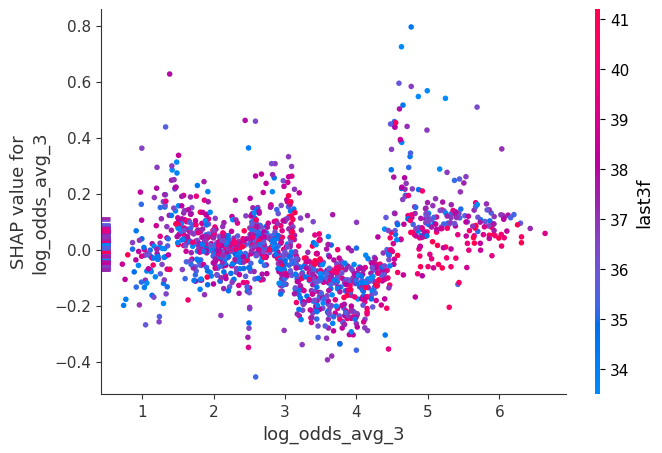

In [11]:
# 例：log_odds_avg_3 の依存プロット（色は last3f）
shap.dependence_plot("log_odds_avg_3", shap_values, X_test, interaction_index="last3f")

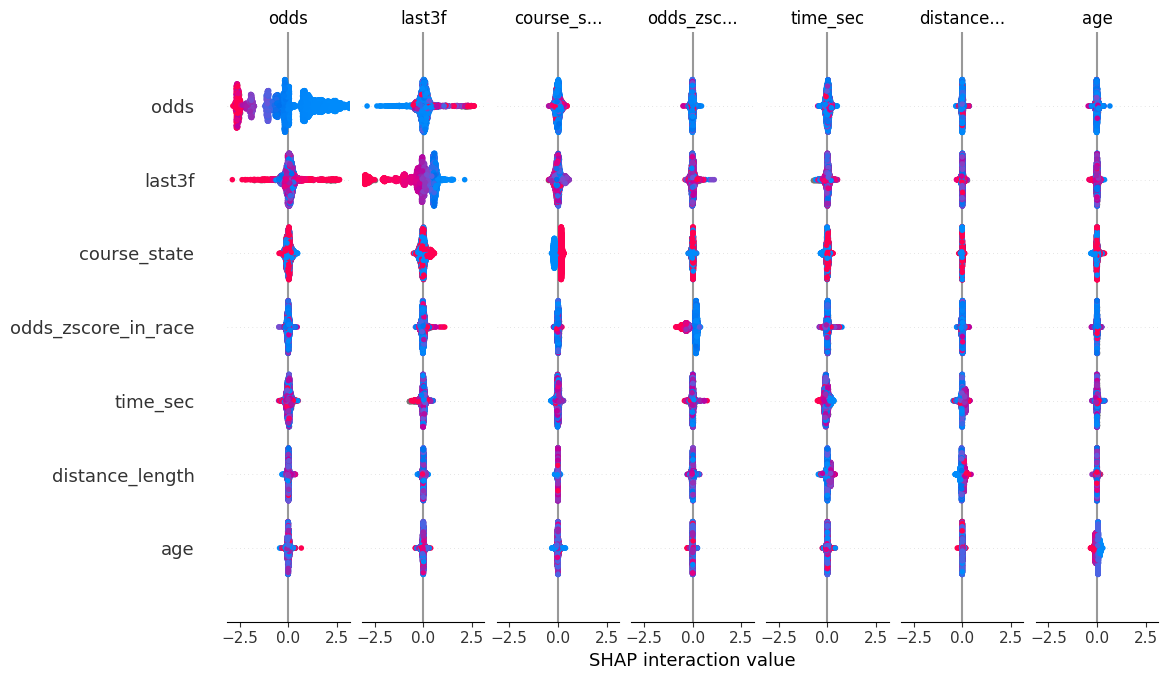

In [12]:
# SHAP interaction values を計算（時間がかかる）
interaction_values = explainer.shap_interaction_values(X_test)

# 例：odds × last3f の交互作用プロット
shap.summary_plot(interaction_values, X_test)

### ランキング学習

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [ ]:
params_rank = {
    'objective': 'lambdarank', # ランキング学習
    'metric': 'ndcg', # 評価指標(NDCG)
    'boosting_type': 'gbdt', # 勾配ブースティング
    'learning_rate': 0.1, # 学習率(小さいほど慎重に学習、ただし学習時間は長くなる)
    'num_leaves': 31, # 木の葉の数(複雑なモデルほど大きく)
    'verbose': -1, # 全てのログの出力を非表示
    'early_stopping_round': 30, # 30回連続で改善しなければ終了
    'num_boost_round': 300 # 最大100本の木を作成
}